# Data wrangling and Analysis about OpenStreetMap in Zurich:
1. Data wrangling process
2. Import data
3. Overview of data files
4. Overview of users
5. Data creation
 - Timeline 
 - The number of ways and nodes changed by different computer programs
6. Overview of nodes and ways
 - What are the most common keys for node_tags and way_tags?
 - What are the most common values for node_tags and way_tags?
 - Who contribute most for nodes and ways?
 - How many tags for one node or one tag? 
 - What are the nodes with most and second most tags?
 - What are the ways with most and second most tags?
7. Explore the map of Zurich
 - Type of street names
 - Number of data in each canton and each district
 - Restaurants types, locations and opening on Sunday
 - Most seen natural scene
 - The most common area code for phone number
 - The most common postcode in the address
8. Appendix
 - Decisions made in wrangling data 
 - Fields without consistent format and didn't process
 - Suggestions for improving and analyzing the data

## Data Wrangling process:
1. Use `get_element.py` to generate data with only 1/10 and 1/100000 size of original data.
2. Use `key_overview.py` to generate to look what are the keys and the values as a reference for further processing.
3. Use `exam.py` to look what types of value would appear in the tag I am going to modify. 
4. Functions used for data processing are all in `clean_format.py` and `is_in.py`.
5. Use `functions.py` to run the whole process.
6. Out put files are:
 - nodes.csv
 - nodes_tags.csv
 - ways.csv
 - ways_nodes.csv
 - ways_tags.csv
7. use sqlite3 to combine all csv files into a data base: `OpenStreetMap.db`
8. Do exploratory data analysis using Jupyter notebook.  

## Import data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import plotly.plotly as py # interactive graphing
import plotly.tools as tls
tls.set_credentials_file(username='XXXXX', api_key='XXXXXX')
tls.embed("https://plot.ly/~streaming-demos/4")
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.graph_objs import Bar, Scatter, Marker, Layout 
import plotly.graph_objs as go
from time import time
import re

import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import gmaps
import gmaps.datasets
api='XXXX'

db = sqlite3.connect("HH2.db")
# another way to initialize database:
# db = create_engine('sqlite:///311_8M.db') # Initializes database with filename 311_8M.db in current directory
# use cursor
# c = db.cursor()
# c.execute("select * from ways_tags where key='highway'")
# c.fetchall()

## Overview of data files:
* nodes.csv: 212.5 MB
* nodes_tags.csv: 15.9 MB
* ways.csv: 24.6 MB
* ways_tags.csv: 43.1 MB
* ways_nodes.csv: 77.6 MB
* OpenStreetMap.db (database includes all files above): 331.5 MB
* raw osm file: 611.5 MB

In [2]:
## number of lines in each file
line_nodes = pd.read_sql_query('SELECT count() FROM nodes',db)['count()']
line_nodes_tags = pd.read_sql_query('SELECT count() FROM nodes_tags',db)['count()']
line_ways = pd.read_sql_query('SELECT count() FROM ways',db)['count()']
line_ways_tags = pd.read_sql_query('SELECT count() FROM ways_tags',db)['count()']
line_ways_nodes = pd.read_sql_query('SELECT count() FROM ways_nodes',db)['count()']
dic_data = {'nodes':line_nodes,'nodes_tags':line_nodes_tags,'ways':line_ways,'ways_tags':line_ways_tags,'ways_nodes':line_ways_nodes}
df_data = pd.DataFrame(dic_data)
df_data

,nodes,nodes_tags,ways,ways_nodes,ways_tags
0,2695275,446304,429887,3298070,1264582


## Overview of users:

In [3]:
c = db.cursor()
# number of unique users:
c.execute('SELECT count(uid) FROM (SELECT uid FROM nodes UNION SELECT uid FROM ways)')
print 'Number of unique users:', c.fetchall()
# number of users contribute only once:
c.execute('SELECT count() FROM\
          (SELECT uid, count() as num \
          FROM (SELECT uid, id FROM nodes UNION ALL SELECT uid, id FROM ways)\
          GROUP BY uid ORDER BY num DESC)  \
          WHERE num=1' 
         )
print 'Number of users only contribute once', c.fetchall()
# users contribute most to nodes:
user_node = pd.read_sql_query('SELECT user, count() as num FROM nodes GROUP BY uid ORDER BY num DESC LIMIT 10',db)
# users contribute most to ways:
user_way = pd.read_sql_query('SELECT user, count() as num FROM ways GROUP BY uid ORDER BY num DESC LIMIT 10',db)
# plot
graph1 = go.Bar(x=user_node.user, y=user_node.num, name='node-user')
graph2 = go.Bar(x=user_way.user, y=user_way.num, name='way-user')
fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('node', 'way'))
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig['layout'].update(height=400, width=800, title='Users contribute most for nodes and ways')
py.iplot(fig, filename='most-common-user')

Number of unique users: [(2550,)]
Number of users only contribute once [(517,)]
This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



## Data creation
### Timeline 

In [4]:
## timestamp of creating nodes
nodes_time = pd.read_sql_query('SELECT timestamp FROM nodes',db)
nodes_time['time'] = nodes_time['timestamp'].str.replace('[\-\d]{3}T.*Z','')
create_time_nodes = nodes_time.groupby('time').count().reset_index()
## timestamp of creating ways 
ways_time = pd.read_sql_query('SELECT timestamp FROM ways',db)
ways_time['time'] = ways_time['timestamp'].str.replace('[\-\d]{3}T.*Z','')
create_time_ways = ways_time.groupby('time').count().reset_index()
create_time = pd.concat([create_time_ways,create_time_nodes])
## plot
graph1 = go.Bar(x=create_time.time, y=create_time.timestamp, name='node')
graph2 = go.Bar(x=create_time.time, y=create_time.timestamp, name='way')
fig = tls.make_subplots(rows=1, cols=2)
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig['layout'].update(height=400, width=1000, title='Time distribution of creating nodes and ways')
py.iplot(fig, filename='created-time-nodes-ways')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### The number of ways and nodes changed by different computer programs 

In [5]:
create = pd.read_sql_query('SELECT value, count()as num FROM\
                            (SELECT id, value FROM nodes_tags WHERE key="created_by" \
                            UNION ALL\
                            SELECT id, value FROM ways_tags WHERE key="created_by")\
                            GROUP BY value ORDER BY num DESC',db)
create

,value,num
0,Potlatch,4929
1,JOSM,2480
2,Merkaartor,1272
3,YahooApplet,41
4,Gabmai,40
5,iLOE,16
6,xybot,16
7,opengeodb2osm0.5.2,12
8,eddiVonDerAlm,6
9,Freddy,2


## Overview of nodes and ways
### Total number of ways and nodes

In [6]:
## number of nodes
c.execute('SELECT count() FROM nodes')
print 'Total number of nodes:', c.fetchall()
## number of ways
c.execute('SELECT count() FROM ways')
print 'Total number of ways:', c.fetchall()

Total number of nodes: [(2695275,)]
Total number of ways: [(429887,)]


### What are the most common keys for node_tags and way_tags?

In [7]:
# most common key for nodes
most_tags_node = pd.read_sql_query('SELECT key, count() as num FROM nodes_tags GROUP BY key ORDER BY num DESC LIMIT 10',db)
# most common key for ways
most_tags_way = pd.read_sql_query('SELECT key, count() as num FROM ways_tags GROUP BY key ORDER BY num DESC LIMIT 10',db)
# plot
# py.iplot([Bar(x=most_tags_node.key, y=most_tags_node.num)], filename='most common tags_key for node')
graph1 = go.Bar(x=most_tags_node.key, y=most_tags_node.num, name='node-key')
graph2 = go.Bar(x=most_tags_way.key, y=most_tags_way.num, name='way-key')
fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('node', 'way'))
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig['layout'].update(height=400, width=800, title='Most common key for node tags and way tags')
py.iplot(fig, filename='most-common-tags-key')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### What are the most common values for node_tags and way_tags?

In [8]:
most_value_node = pd.read_sql_query('SELECT key, value, count() as num FROM nodes_tags GROUP BY value ORDER BY num DESC LIMIT 10',db)
most_value_node['key-value'] = most_value_node.key.str.cat(most_value_node.value, sep='-')
most_value_way = pd.read_sql_query('SELECT key, value, count() as num FROM ways_tags GROUP BY value ORDER BY num DESC LIMIT 10',db)
most_value_way['key-value'] = most_value_way.key.str.cat(most_value_way.value, sep='-')

graph1 = go.Bar(x=most_value_node['key-value'], y=most_tags_node.num, name='node-value')
graph2 = go.Bar(x=most_value_way['key-value'], y=most_tags_way.num, name='way-value')
fig = tls.make_subplots(rows=1, cols=2, subplot_titles=('node', 'way'))
fig.append_trace(graph1, 1, 1)
fig.append_trace(graph2, 1, 2)
fig['layout'].update(height=400, width=800, title='Most common value for node tags and way tags (key-value)')
py.iplot(fig, filename='most-common-tags-value')



This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### How many tags for one node or one tag?

Top 5 nodes with most tags:
           id  num
0   240025182  123
1    26608880   50
2  1437520591   30
3    30757710   28
4    29973040   27

Top 5 ways with most tags:
          id  num
0  248446830   30
1   93699765   26
2  108502462   23
3   38909155   22
4  116433926   21


[<matplotlib.text.Text at 0x10de20e10>, <matplotlib.text.Text at 0x13a946a90>]

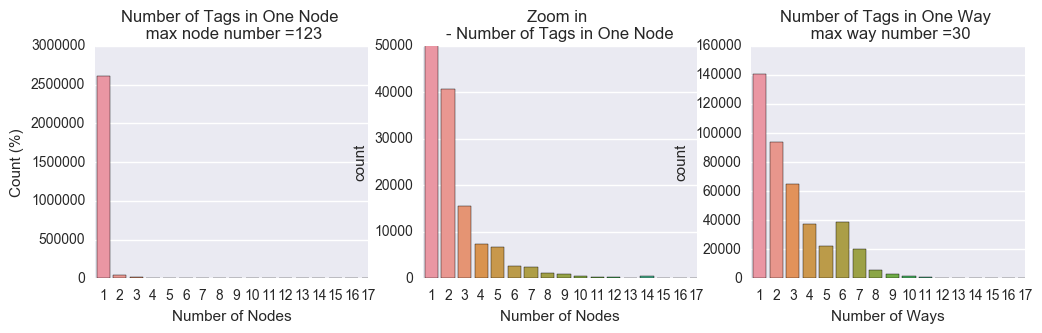

In [9]:
node_num = pd.read_sql_query('SELECT nodes.id, count() as num \
                             FROM nodes LEFT JOIN nodes_tags \
                             ON nodes.id=nodes_tags.id \
                             GROUP BY nodes.id ORDER BY num DESC',db)
way_num = pd.read_sql_query('SELECT ways.id, count() as num \
                             FROM ways LEFT JOIN ways_tags \
                             ON ways.id=ways_tags.id \
                             GROUP BY ways.id ORDER BY num DESC',db)
print 'Top 5 nodes with most tags:'
print node_num.head()
print 
print 'Top 5 ways with most tags:'
print way_num.head()

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))
g=sns.countplot(x='num',data=node_num,ax=ax1)
g.set(xlim=(-0.5,16),xlabel='Number of Nodes')
g.set(title='Number of Tags in One Node \n max node number ='+str(node_num['num'][0]),ylabel='Count (%)')
g=sns.countplot(x='num',data=node_num,ax=ax2)
g.set(xlim=(-0.5,16))
g.set(ylim=(0,50000))
g.set(title='Zoom in \n- Number of Tags in One Node',xlabel='Number of Nodes')
g=sns.countplot(x='num',data=way_num,ax=ax3)
g.set(xlim=(-0.5,16))
g.set(title='Number of Tags in One Way \n max way number ='+str(way_num['num'][0]),xlabel='Number of Ways')
# node_num = pd.read_sql_query('SELECT nodes.id, count() as num FROM nodes LEFT JOIN nodes_tags ON nodes.id=nodes_tags.id GROUP BY nodes.id ORDER BY num DESC',db)

### What's node with most tags

In [10]:
 pd.read_sql_query('SELECT type, key, value \
                   FROM nodes_tags\
                   WHERE id IN \
                   (SELECT nID FROM\
                   (SELECT nodes.id as nID, count() as num\
                   FROM nodes LEFT JOIN nodes_tags \
                   ON nodes_tags.id= nodes.id\
                   GROUP BY nodes.id\
                   ORDER BY num DESC\
                   LIMIT 1))',db)

,type,key,value
0,admin_centre,4,yes
1,regular,ele,408
2,is_in,canton,Zürich
3,is_in,district,Zürich
4,is_in,local_name,Zürich
5,is_in,continent,Europe
6,is_in,country,Switzerland
7,is_in,country_code,CH
8,is_in,iso_3166_2,CH-ZH
9,is_in,state,Zürich


### What is the node with the second most tags

In [11]:
# see the tags for the second largest node
pd.read_sql_query('SELECT type, key, value\
                   FROM nodes_tags\
                   WHERE id in \
                   (SELECT nID FROM\
                   (SELECT nodes.id as nID, count() as num\
                   FROM nodes LEFT JOIN nodes_tags \
                   ON nodes_tags.id= nodes.id\
                   GROUP BY nodes.id\
                   ORDER BY num DESC\
                   LIMIT 1 OFFSET 1))',db)

,type,key,value
0,regular,ele,432
1,regular,ref,ZRH
2,regular,iata,ZRH
3,regular,icao,LSZH
4,regular,name,Flughafen Zürich
5,regular,type,Public
6,is_in,canton,Zürich
7,is_in,district,
8,is_in,local_name,
9,regular,source,wikipedia


### What is the way with most tags?

In [12]:
pd.read_sql_query('SELECT type, key, value \
                   FROM ways_tags\
                   WHERE id IN \
                   (SELECT wID FROM\
                   (SELECT ways.id as wID, count() as num\
                   FROM ways LEFT JOIN ways_tags \
                   ON ways_tags.id= ways.id\
                   GROUP BY ways.id\
                   ORDER BY num DESC\
                   LIMIT 1))',db)

,type,key,value
0,regular,name,Wertstoffsammelstelle Schanz
1,regular,phone,+41449525354
2,regular,amenity,recycling
3,regular,website,http://www.gwpfaeffikon.ch/cms/index.php/abfal...
4,regular,building,yes
5,addr,street,Schanzstrasse
6,addr,postcode,8330
7,regular,opening_hours,Mo-Fr 09:00-12:00; 14:00-17:00
8,recycling,cans,yes
9,recycling,wood,yes


### What is the way with second most tags?

In [13]:
pd.read_sql_query('SELECT type, key, value \
                   FROM ways_tags\
                   WHERE id IN \
                   (SELECT wID FROM\
                   (SELECT ways.id as wID, count() as num\
                   FROM ways LEFT JOIN ways_tags \
                   ON ways_tags.id= ways.id\
                   GROUP BY ways.id\
                   ORDER BY num DESC\
                   LIMIT 1 OFFSET 1))',db)

,type,key,value
0,regular,name,Hotel Arlette
1,regular,stars,2
2,regular,source,Stadt Zürich Open Government Data; Geomatik + ...
3,regular,tourism,hotel
4,regular,building,yes
5,addr,city,Zürich
6,addr,street,Stampfenbachstrasse
7,payment,jcb,yes
8,addr,country,CH
9,payment,cash,yes


In [14]:
pd.read_sql_query('SELECT type, key, value \
                   FROM ways_tags\
                   WHERE id IN \
                   (SELECT wID FROM\
                   (SELECT ways.id as wID, count() as num\
                   FROM ways LEFT JOIN ways_tags \
                   ON ways_tags.id= ways.id\
                   GROUP BY ways.id\
                   ORDER BY num DESC\
                   LIMIT 1 OFFSET 4))',db)

,type,key,value
0,regular,name,Tibits
1,regular,phone,+41442603222
2,regular,height(m),14
3,regular,source,Stadt Zürich Open Government Data; Geomatik + ...
4,regular,amenity,restaurant
5,regular,cuisine,vegetarian
6,regular,smoking,outside
7,regular,website,http://www.tibits.ch/
8,regular,building,yes
9,regular,takeaway,yes


** In general, more tags were used to describe nodes than ways. The first two nodes with most tags are the city of Zurich and Zurich airport. Most of the tags are used to describe the name in different languages. For tags of way, the most tagged way is a recycling center. Most tags are used to describe the material for recycling. The 2nd most tagged way is a hotel, with tags descrbing the way of payment. The 3rd most tagged way is a gas station, with tags descrbing the provided fuel. ** 

## Explore Zurich
### The type of street names in Zurich

([<matplotlib.axis.XTick at 0x12979f2d0>,
 <a list of 4 Text xticklabel objects>)

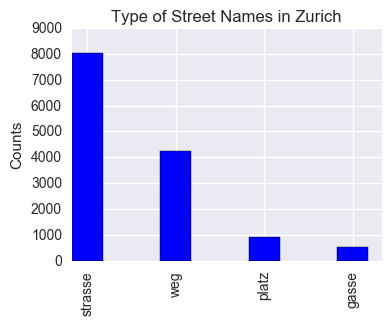

In [15]:
count_strasse = pd.read_sql_query('SELECT SUM(num) FROM\
                                  (SELECT count(DISTINCT value) as num FROM nodes_tags WHERE UPPER(value) LIKE "%STRASSE%"\
                                  UNION ALL\
                                  SELECT count(DISTINCT value) as num FROM ways_tags WHERE UPPER(value) LIKE "%STRASSE%")\
                                  ',db)
count_weg = pd.read_sql_query('SELECT SUM(num) FROM\
                                  (SELECT count(DISTINCT value) as num FROM nodes_tags WHERE UPPER(value) LIKE "%WEG%"\
                                  UNION ALL\
                                  SELECT count(DISTINCT value) as num FROM ways_tags WHERE UPPER(value) LIKE "%WEG%")\
                                  ',db)
count_platz = pd.read_sql_query('SELECT SUM(num) FROM\
                                  (SELECT count(DISTINCT value) as num FROM nodes_tags WHERE UPPER(value) LIKE "%PLATZ%"\
                                  UNION ALL\
                                  SELECT count(DISTINCT value) as num FROM ways_tags WHERE UPPER(value) LIKE "%PLATZ%")\
                                  ',db)
count_gasse = pd.read_sql_query('SELECT SUM(num) FROM\
                                  (SELECT count(DISTINCT value) as num FROM nodes_tags WHERE UPPER(value) LIKE "%GASSE%"\
                                  UNION ALL\
                                  SELECT count(DISTINCT value) as num FROM ways_tags WHERE UPPER(value) LIKE "%GASSE%")\
                                  ',db)
street_type = ['strasse','weg','platz','gasse']
street_count = [count_strasse['SUM(num)'][0],count_weg['SUM(num)'][0],count_platz['SUM(num)'][0],count_gasse['SUM(num)'][0]]

ind = np.arange(len(street_count))  # the x locations for the groups
width = 0.35       # the width of the bars
plt.figure(figsize=(4,3))
plt.bar(range(len(street_count)), street_count, width, color='b')

plt.ylabel('Counts')
plt.title('Type of Street Names in Zurich')
plt.xticks(ind + width / 2, street_type,  rotation='vertical')


### Number of data in each canton and each district

In [16]:
canton = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM\
                        (SELECT id, value FROM nodes_tags WHERE key="canton"\
                        UNION ALL\
                        SELECT id, value FROM ways_tags WHERE key="canton")\
                        GROUP BY value',db)
print 'number of data in each canton:'
print canton
print
district = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM\
                        (SELECT id, value FROM nodes_tags WHERE key="district"\
                        UNION ALL\
                        SELECT id, value FROM ways_tags WHERE key="district")\
                        GROUP BY value',db)
print 'number of data in each district:'
print district

number of data in each canton:
    value  count(DISTINCT id)
0                          62
1  Aargau                 150
2  Zürich                 231

number of data in each district:
         value  count(DISTINCT id)
0                              230
1    Affoltern                  13
2        Baden                  48
3   Bremgarten                  26
4       Bülach                  17
5    Dielsdorf                  21
6     Dietikon                  11
7       Hinwil                   5
8       Horgen                   7
9      Kreis 9                   1
10      Meilen                  14
11        Muri                   9
12   Pfäffikon                  27
13       Uster                   6
14  Winterthur                   7
15     Zurzach                   2
16      Zürich                   1


** Most of the data came from Zurich (52%). 34% data came from another canton: Aargau. 14% data contain too few information to find its canton.**

### Restaurants types, locations and opening on Sunday

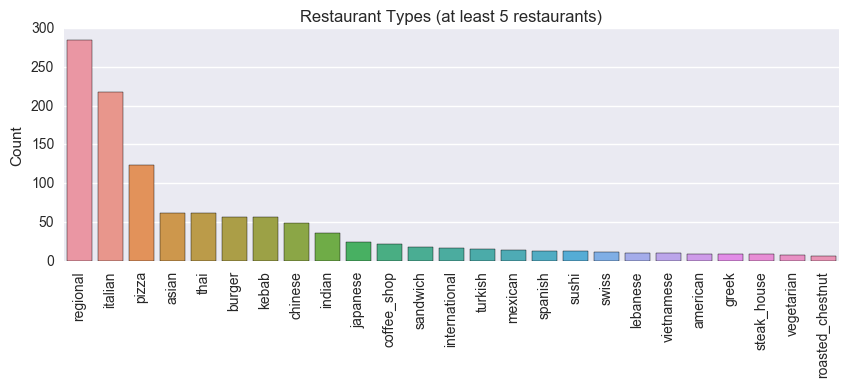

In [17]:
## Number of resturants with more than 5 shops
cuisine = pd.read_sql_query('SELECT value, count() as num FROM \
                            (SELECT value, id FROM nodes_tags WHERE key="cuisine" \
                            UNION ALL SELECT value, id FROM ways_tags WHERE key="cuisine") a \
                             GROUP BY value HAVING num>5 ORDER BY num DESC',db)
plt.figure(figsize=(10,3))
g = sns.barplot(x='value',y='num',data=cuisine)
g.set_xticklabels(cuisine.value, rotation=90)
g.set(title='Restaurant Types (at least 5 restaurants)',xlabel='',ylabel='Count')

[<matplotlib.text.Text at 0x12d7a83d0>, <matplotlib.text.Text at 0x12d946710>]

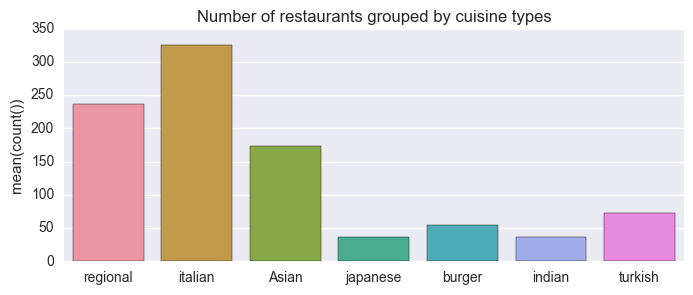

In [18]:
## group these types of restaurants, to see the number:
# 1. regional, swiss, local
# 2. italian, pizza
# 3. asian, chinese, thai, vietnamese
# 4. japanese, sushi
# 5. american, burger
# 6. indian
# 7. turkish, kebab, falafel
swiss = pd.read_sql_query('SELECT value, count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%REGIONAL%" OR UPPER(value) LIKE "%SWISS%" OR UPPER(value) LIKE "%LOCAL%")',db)
pizza = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%ITALIAN%" OR UPPER(value) LIKE "%PIZZA%")',db)
asian = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%VIETNA%" OR UPPER(value) LIKE "%CHINESE%" OR UPPER(value) LIKE "%THAI%" OR UPPER(value) LIKE "%ASIAN%")',db)
japan = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%JAPAN%" OR UPPER(value) LIKE "%SUSHI%")',db)
usa = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%AMERICA%" OR UPPER(value) LIKE "%BURGER%")',db)
indian = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%INDIAN%")',db)
kebab = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%TURKISH%" OR UPPER(value) LIKE "%KEBAB%" OR UPPER(value) LIKE "%FALAFEL%")',db)

type_cuisine = pd.concat([swiss,pizza,asian,japan,usa,indian,kebab])
type_cuisine.loc[type_cuisine['value']=='vietnamese','value']='Asian'
plt.figure(figsize=(8,3))
g = sns.barplot(x='value',y='count()',data=type_cuisine)
g.set(xlabel='',title='Number of restaurants grouped by cuisine types')


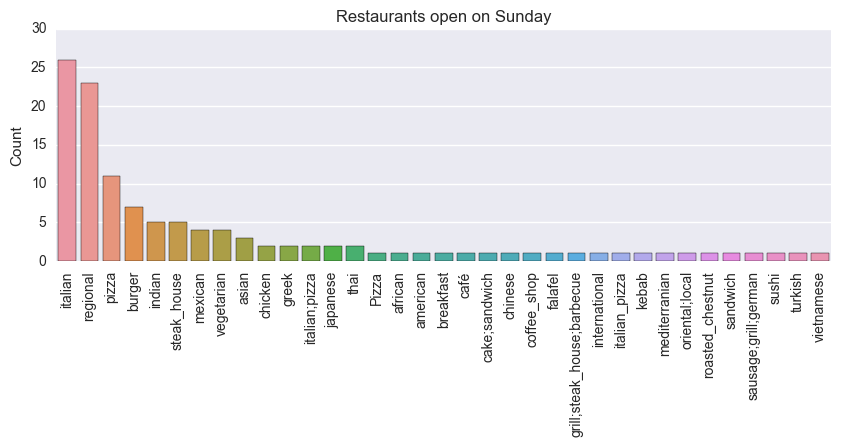

In [19]:
## Types and number of restaurant opens on Sunday
sun_open_restaurant = pd.read_sql_query('SELECT value, count() as num FROM\
                   (SELECT id, value FROM nodes_tags WHERE id IN\
                   (SELECT id FROM \
                   (SELECT id, key, value FROM nodes_tags WHERE id IN (SELECT id FROM nodes_tags WHERE key="cuisine")) a\
                   WHERE key="opening_hours" AND value LIKE "%Su ____%") \
                   AND key="cuisine" \
                   UNION ALL\
                   SELECT id, value FROM ways_tags WHERE id IN\
                   (SELECT id FROM \
                   (SELECT id, key, value FROM ways_tags WHERE id IN (SELECT id FROM ways_tags WHERE key="cuisine")) a\
                   WHERE key="opening_hours" AND value LIKE "%Su ____%") \
                   AND key="cuisine")\
                   GROUP BY value ORDER BY num DESC',db)
plt.figure(figsize=(10,3))
g = sns.barplot(x='value',y='num',data=sun_open_restaurant)
g.set_xticklabels(sun_open_restaurant.value,rotation=90)
g.set(title='Restaurants open on Sunday',xlabel='',ylabel='Count')

In [20]:
lat_lon_italy = pd.read_sql_query('SELECT lat, lon FROM nodes WHERE id IN\
                  (SELECT id FROM nodes_tags WHERE key="cuisine" AND (UPPER(value) LIKE "%ITALIAN%" OR UPPER(value) LIKE "%PIZZA%"))\
                  ',db)
lat_lon_regional = pd.read_sql_query('SELECT lat, lon FROM nodes WHERE id IN\
                  (SELECT id FROM nodes_tags WHERE key="cuisine" AND (UPPER(value) LIKE "%REGIONAL%" OR UPPER(value) LIKE "%LOCAL%"))\
                  ',db)
lat_lon_sunday = pd.read_sql_query("SELECT lat, lon FROM nodes WHERE id IN\
                                   (SELECT id FROM \
                                   (SELECT id, key, value FROM nodes_tags WHERE id IN\
                                   (SELECT id FROM nodes_tags WHERE key='cuisine'))\
                                   WHERE key='opening_hours' AND value LIKE '%Su ____%')",db)

## plot gmap
italy = [tuple(x) for x in lat_lon_italy.values]
regional = [tuple(x) for x in lat_lon_regional.values]
sunday = [tuple(x) for x in lat_lon_sunday.values]
gmaps.configure(api_key=api) # Your Google API key

italy_layer = gmaps.symbol_layer(italy, fill_color="blue", stroke_color="blue")
regional_layer = gmaps.symbol_layer(regional, fill_color="red", stroke_color="red")
sunday_layer = gmaps.symbol_layer(sunday, fill_color="green", stroke_color="green")
m = gmaps.Map()
m.add_layer(italy_layer)
m.add_layer(regional_layer)
m.add_layer(sunday_layer)
m


** 1. If we regards pizza as italian food, then Italian food would be the most common cuisine in Zurich. regional cuisine would be the second, then asian cuisine. Italian (blue points) and regional cuisine (red points) doesn't localize at certain region. **

** 2. Only less than 10% of restaurnats open on Sunday (green points). These restaurants does not localize at certain region either. **

## Most seen natural scene

#1 of most seen natural scene: tree with number: 163961


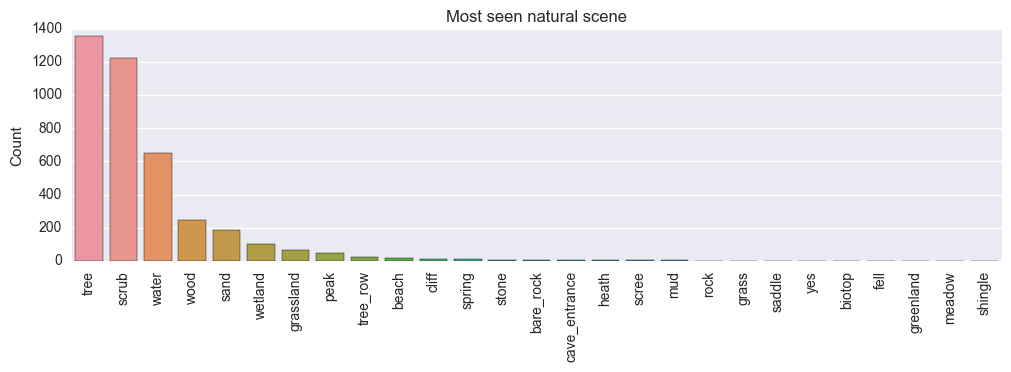

In [21]:
## Most seen natural scene
natural_scene = pd.read_sql_query('SELECT value, count() as num FROM\
                   (SELECT value, id FROM nodes_tags WHERE key="natural" \
                   UNION ALL\
                   SELECT value, id FROM ways_tags WHERE key="natural")\
                   GROUP BY value ORDER BY num DESC',db)
print '#1 of most seen natural scene:',natural_scene.loc[0,'value'] ,'with number:',natural_scene.loc[0,'num']
plt.figure(figsize=(12,3))
g = sns.barplot(x='value',y='num',data=natural_scene[1:])
g.set_xticklabels(natural_scene.value,rotation=90)
g.set(title='Most seen natural scene',xlabel='',ylabel='Count')

### The most common  postcode in the address

In [22]:
pd.read_sql_query('SELECT value, count() as num FROM\
                   (SELECT id, value FROM nodes_tags WHERE type="addr" AND key="postcode"\
                   UNION ALL\
                   SELECT id, value FROM ways_tags WHERE type="addr" AND key="postcode")\
                   GROUP BY value ORDER BY num DESC LIMIT 10',db)

,value,num
0,8610,3367
1,8032,2700
2,5430,2606
3,8700,2471
4,8706,2445
5,8008,2399
6,8001,2378
7,8006,2378
8,8051,2321
9,8057,2144


### The most common area code for phone number

In [23]:
phoneList=pd.read_sql_query('SELECT DISTINCT value FROM\
                   (SELECT value FROM nodes_tags WHERE UPPER(key) LIKE "%PHONE%"\
                   UNION ALL\
                   SELECT value FROM ways_tags WHERE UPPER(key) LIKE "%PHONE%")\
                  ',db)
regional_code = pd.DataFrame(list(phoneList['value'].str.extractall('\+41(\d{2}).*')[0]),columns=['code'])
regional_code = regional_code.reset_index().groupby('code').count().sort_values(by='index',ascending=False)
regional_code = regional_code.reset_index()

## online search for area code and the corresponding company 
s=requests.Session()
r = s.get('https://www.ecallchina.com/country/Switzerland-area-code.aspx')
soup = BeautifulSoup(r.text,"html.parser")
table = soup.find(id='dg_countrycode')

line_dict = defaultdict()
company_dict = defaultdict()
rm = re.compile(r'Festnetzdienste|Telefonie|ISDN\s\/\sPSTN|Unternehemnsweite|Mobile|Fernmeldedienste|Funkrufdienste|GSM\sTDC|GSM\s\/\sUMTS')
for i, tr in enumerate(table.find_all('tr')):
    if i >1:
        a = tr.find('td')
        area_code = a.text[2:4]
        line_form = a.next_sibling
        line_dict[area_code] = line_form.string
        company_dict[area_code] = re.sub(rm,'',line_form.next_sibling.string).strip()

# create a dataframe "area_code_df" to show how the phone code is related to area and the company 
code_df = pd.DataFrame(regional_code['code'])
def get_value(x):
    if x in line_dict.keys():
        return line_dict[x]
    else:
        return None
def get_company(x):
    if x in company_dict.keys():
        return company_dict[x]
    else:
        return None
area_code_df= pd.DataFrame(code_df['code'])
area_code_df['count'] = regional_code['index']
area_code_df['line'] = code_df.applymap(get_value)
area_code_df['company'] = code_df.applymap(get_company)
area_code_df

,code,count,line,company
0,44,1197,Fix Line,COLT Telecom AG
1,43,263,Fix Line,Cablecom GmbH
2,56,243,Fix Line,Cablecom GmbH
3,52,153,Fix Line,Cablecom GmbH
4,79,52,Mobile,Global Networks Inc.
5,58,28,Fix Line,Fernmeldenetze Swisscom Fixnet AG
6,76,22,Mobile,Mobiltelefonie Schweiz AG
7,55,16,Fix Line,Cablecom GmbH
8,04,13,None,None
9,84,12,None,None


## Appendix
### Decisions made in data wrangling -- tags
#### Address related:
#####   "is_in" 
    is_in Bezirk Bremgarten,Aargau,Schweiz,Europe
    is_in Kyburg,Bezirk Pfäffikon,Zürich,Schweiz,Europe
    is_in Dübendorf,Schweiz,Europe
    is_in Tägerig
    is_in Egg
    is_in CH,Schlieren
    is_in Pfäffikon ZH
> Add **canton, district, local_name** as new 'key'. 
> Use **is_in** as 'type'.
>`get_kantonBezirk()` to get information about "canton" and "district"
>1. Remove CH, Schweiz, Europe, Switzerland.
>2. Find canton (Kanton).
> - Search for AG or ZH or Aargau or Zurich.
>3. Find district (Bezirk).
> - Search for word 'Bezirk' or any word in the list of districts.
> - `get_distinct()` is used to get the list of distincts in one canton.
>4. If find district, use district to fill canton. 
>5. If no information about district and canton is found, `fix_problem_is_in()` will search in wikipedia and find the canton name.
>6. If the input information is not clear enough to get the canton or district name, the output will be empty.

##### "addr:state"
    addr:state ZH
    addr:state Zurich
    addr:state CH
> Change ZH or CH to Zurich 
      
##### "addr:city"
    addr:city Winterberg ZH
    addr:city Tagelswangen
    addr:city Waldegg
    addr:city Birmensdorf (ZH)
    addr:city Ottikon
    addr:city Muri AG
    addr:city Geltwil/AG
> Remoev ZH/AG related and all words in the parenthesis.


#### Phone related
##### "phone", "fax", "contact:phone", "contact:fax", "phone:mobile", "contact:mobile"
    phone +41448606555
    phone +41 44 817 69 20
    phone 0432110222
    phone +41 (0)56 426 31 12
    phone 043 366 8294
    phone yes
    phone +41 44 635 87 56 oder +41 44 635 81 12;Notfall: +41 635 81 11
    phone +41 (0)55 615 36 67;+41 (0)79 524 20 88
    phone +41 (0)56 282 44 79 / +41 (0)77 79 08 05
    phone (+41)044 536 35 53/(+41)079 158 77 77
    contact:phone +41 52 3542448
    contact:mobile +41 76 412 47 85
> Make every phone with this format `+41448606555` 
> 
 - the those show + but not +41, the first two number would be considered as the regional code (e.g., +442115550)
 - If more than one phone is listed, only choose the first one
 - As long as no actual phone number is listed, the value would be empty
 


#### Simplification
##### Ignore version: "created_by"
    created_by Gabmai
    created_by Potlatch 0.5d
    created_by opengeodb2osm0.5.2
    created_by wikipost_osmService
    created_by Potlatch 0.4b
    created_by iLOE 1.9
    created_by YahooApplet 1.0
> Remote infomation about versions, just leave the name of the application.

##### "lines", "line", "route_ref", "busline"
    lines 3,5,14,N65
    lines 1,5,7,11;1,4,5,7,11,N66
    lines 767
    lines 665;670;676
    
    line 640
    line 655
    line busbar
    line bus
    
    route_ref 2, N68
    route_ref 2,3
    route_ref 2
    route_ref 2,9
 
> Use the same rule for _line_ and _lines_: separate different lines with ','
> Combine the information to only output the total number of buses 
> for those without writting the bus line number will output as an empty list []
  * id: the id of upper layer (from node or way)
  * key: **line** 
  * value: **number of buses or 0**
  * type: **bus** 

##### highway: 'destination:ref'
    destination:ref A1
    destination:ref A1;A4
    destination:ref 7
    destination:ref A 3
    destination:ref Zürich-Wollishofen
> A stands for 'Autobahn' in German. The output would be a list of all numbers. 'Zürich-Wollishofen' would be A3 [ref](https://www.autobahnen.ch/forum/viewtopic.php?t=26&start=105)


#### Unit related
##### "width", "height", "distance", "maxstay", "building:height", "maxwidth", "depth"
    width 1m
    width .5
    distance 9.5 km
    distance 39
    height 6
    height 45 m
    maxstay 6 hours
    maxstay 600
    maxstay 12h
    maxstay hour/12
    building:height 7 m
    maxwidth 2 m ¦ none
    depth 15m
    depth 7m
    min_age 18
    min_age 3 months
    min_age 10
    
> 1. remove the unit 
> 2. put the unit into the key 
> 3. hour/12 is regarded as 12 hr
>   * key for width: **width (m)**
>   * key for height **height (m)**
>   * key for distance **distance (km)**
>   * key for maxstay **maxstay (hr)**

##### language
    wikipedia de:Wangen-Brüttisellen
    wikipedia de:Kanton Luzern
    wikipedia en:Schrödinger's cat
> use wikipedia as type
> language as key

#### Date related
##### "survey:date", "time", "xmas:day_date", "start_date", "end_date", "temporary:date_on"
    survey:date 2016-06-05
    start_date ~1950
    start_date 1967
    start_date 07/2016
    xmas:day_date 06.12.2014-23.12.2014
    time 2006-01-15T07:57:33Z
    end_date 2016-12-24
    temporary:date_on 2014-08-20  
    opening_date 2019
    opening_date 2018-08-01
> change to "Year", "Month", "Day"

##### "kitchen_hours", "opening_hours", "opening_hours:reading_room", "opening_hours_1",  "service_times", "collection times"
    opening_hours_1 Mo- Fr 07.00-19.00; Sa 07.00-17.00; Su 7:00-13:00
    opening_hours:reading_room Mo-Fr 09:00-20:00; Sa 09:00-18:00
    kitchen_hours Mo-Fr 11:30-14:00,17:30-22:00; Sa 17:00-22:00
    kitchen_hours Mo-Sa 11:00-14:00,17:00-22:00
    opening_hours Mo-Sa 08:00-20:00; PH off
    opening_hours Mo-Sa 09:00-20:00
    opening_hours Mo-We 08:00-19:00; Th 08:00-20:00; Fr 07:30-15:00; Su off
    opening_hours Mo-Fr 9:00-20:00; Sa 9:00-18:00
    opening_hours 08:00-24:00
    opening_hours Tu-Fr 10:00-18:30; Sa 10:00-16:00
    opening_hours Mo-Fr 08:30-23:00, Sa-Su off
    opening_hours Mo-Fr 08:00-19:00; Sa 08:00-17:00
    opening_hours Sa 9:00-12:00
    opening_hours Su-Th 12:00-01:00; Fr-Sa 12:00-02:00; PH -1 day: 12:00-02:00
    opening_hours Montag geschlossen  Dienstag 09:00 - 13:00 / 13:30 - 18:30  Mittwoch + Donnerstag  10:00 - 13:00 / 13:30 - 18:30  Freitag 09:00 - 13:00 / 13:30 - 18:30  Samstag 10:00 - 16:00
    opening_hours Mo 14:00-19:00; Tu-Fr 10:00-19:00; Sa 10:00-17:00; Oct-Feb: Tu-Fr 11:00-19:00; Oct-Feb: Sa 10:00-16:00; Oct-Feb: Mo off
    opening_hours Tu-Su 10:00-17:00; Jun-Sep: Th 10:00-20:00
    opening_hours 24/7
    opening_hours Di.-Fr. 8:00-12:00 / 13:30-18:30; Sa. 8:00-16:00; Mo. geschlossen
    opening_hours url: http://www.schuhmacherdidiaenzo.ch/index_6.htm
    opening_hours Mo-Fr 07:30-15:30
    opening_hours Tu-Fr 9:00-12:00, 14:00-18:30; Sa 9:00-14:00
    opening_hours Mo-Sa 10-11:30
    
    collection_times Mo-Fr 18:30; Su 16:00
    collection_times Mo-Fr 18:15; Su 17:00; PH 17:00
    collection_times Mo-Fr 18:15; Sa 13:00
    collection_times Mo-Fr 17:30; So 16:00, SH 16:00
    
    service_times random
    service_times Sa 09:30-12:00
> The output format would be:
`Mo off;Tu 09:00-13:00,13:30-18:30;We-Th 10:00-13:00,13:30-18:30;Fr 09:00-13:00,13:30-18:30;Sa 10:00-16:00`

### Fields without consistent format and didn't process:
#### With too much information
##### contains notes, suggestions...
* description
* note
* note:de
* access:note
* ref
* FIXME
* source
* inscription
* comment
* info
> The value of these fields can be everything and some in English some in German. It would only be possible to process with a specific questions (so you can look for a specific key words).  

##### locations
   via Winterthur;Stadelhofen;Zürich HB;Dietikon;Baden
   via Zürich HB - Rapperswil - Uster
   via Brugg–Baden
   via Zürich HB - Zürich Oerlikon -Otelfingen
   via Medikon
   via Escher-Wyss-Platz
   from Wetzikon ZH, Bahnhof
   from Adliswil, Bahnhof
   from Hausen am Albis, Post
* destination
* from
* via
> It's not clear how these places are chosen so it's also difficult to make the format consistent.
       
#### Different entry types matter/work: 
##### "maxspeed", "maxspeed:forward",  "maxheight", "restriction"
    maxspeed signals
    maxspeed 140
    maxspeed 10
    maxspeed CH:rural
    maxspeed:forward 80
    maxspeed:forward CH:rural
    maxheight default
    maxheight 3.4
    maxheight 3.7
    restriction 00:00 - 04:00
    restriction only_right_turn
    restriction no_u_turn
    restriction no_left_turn
    
> 'signals' or 'CH:rural' or 'default' has their own meanings and cannot be converted to number 
> Both restriction in time and turn have meaning
   
##### website
    contact:website http://www.unterstrass.edu/gymnasium/
    contact:website www.sibler.com
> Either format can function so it's fine to leave it. 

#### Unable to define mis-matched data
##### "addr:housenumber"
    addr:housenumber 20 - 28
    addr:housenumber 12, 14
    addr:housenumber 5, 7, 9
    addr:housenumber 345
    addr:housenumber 21-21b
    addr:housenumber 65g
    addr:housenumber 44a,44b
    addr:housenumber 22, 24, 26, 28
    addr:housenumber 11-15
    addr:housenumber 1 C
    addr:housenumber 11a-e
    addr:housenumber 40;40a
    addr:housenumber 10-10a  
> It's not clear what the range should include.

##### color
    colour #00BF2C
    colour #8D1D2C
    colour blue
    roof:colour brown
    roof:colour #C5B399
    roof:colour gray
    roof:colour lightgrey
    roof:colour grey
    roof:colour #999999
    roof:colour 582121
    roof:colour #AAAAAA
    roof:colour c7c7c7
    roof:colour #582121
    roof:colour green
    roof:colour white
    roof:colour lightsteelblue
> It's difficult to convert the descriptive color into Hex (RGB) and vice versa.

##### stars
    stars Su-Fr 08:30-14:30, 17:00-23:30, Sa 17:00-23:30
    stars 1
    stars 3
    stars 2

##### "fee", "payment"
    fee täglich 07:00-22:00 1 CHF/h
    fee no
    fee interval
    fee 1 CHF
    fee CHF 5 / day
    fee 2.5 h for free
    fee 2 CHF/h (CHF 1 for the first hour) 2011-05-21
    fee For visitors of BBZ
    fee yes
    fee Visitor Parking Schöneggstrasse 104/102
    fee Mo-Fr 08:00-19:00;Sa 08:00-16:00
    fee Rüti - Rüti ZH - Bubikon - Hombrechtikon - Stäfa, Frohberg
    fee no
    fee:centralkey no


### Suggestions for improving and analyzing the data
1. To consider tags in both ways and nodes, usually I need to do `UNION ALL` in sql. The query is the same but replace nodes with way and this makes the query lengthy. It's not possible to combine ways and nodes to a bigger database, as the fields in nodes are different from ways. A more efficient way would be **avoiding mixing the tags for ways and nodes**. Then we can only look at either _ways_ or _nodes_ instead of trying to union them all the time. 
2. I actually use pandas to analyze the area phone code. This is because I didn't make a separated key for area code.  For possible analyzed fields, it would be nice to make separate keys and values for them so the answer can be easily retrieved by sql query.
3. It's a bit complicated to analyze multiple keys related to one node or way. For example, when I analyzed the location of restaurants based on their cuisine type and opening hour, I need to first find the id for key='cuisine' and then use these id to find those key='opening_hour', and finally can use these id to get the location. The more condition you want to have, the more layers (subqueries) of the sql query. It would be much easier to analyze multiple condition if different conditions are different columns of the table (then we only need several AND instead of several SUBQUERY). Therefore, if it's clear about the direction of analysis, it would be nice to put all related keys into a separate database. For instance:

```CREATE TABLE food (
    id INTEGER NOT NULL,
    cuisine_type TEXT NOT NULL,
    opening_hours TEXT NOT NULL,
    address TEXT
    FOREIGN KEY (id) REFERENCES nodes(id)
 );```